# Decision Trees Exercises

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [1]:
from __future__ import print_function
import os
data_path = ['..', 'data']

## Question 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.

In [2]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')
print(data["color"].value_counts())
data.head()

white    4898
red      1599
Name: color, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [4]:
data["color"] = data.color.replace({
    "white": 0,
    "red": 1
}).astype(int)

## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = data.columns[:-1]

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data["color"]))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, "color"]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, "color"]

In [6]:
y_train.value_counts(normalize=True)

0    0.753904
1    0.246096
Name: color, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

0    0.753846
1    0.246154
Name: color, dtype: float64

## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?

In [8]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X_train, y_train)


In [9]:
dtc.tree_.node_count, dtc.tree_.max_depth

(143, 18)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    errors = pd.Series({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }, name=label)
    return errors

In [11]:
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

train_test_full_error = pd.concat([
    measure_error(y_train, y_train_pred, "train"),
    measure_error(y_test, y_test_pred, "test")
], axis=1)

train_test_full_error

,train,test
accuracy,0.999780,0.990769
precision,0.999107,0.977273
recall,1.000000,0.985417
f1,0.999553,0.981328


## Question 4

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "max_depth": range(1, dtc.tree_.max_depth+1, 2),
    "max_features": range(1, len(dtc.feature_importances_)+1)
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                    param_grid=parameters,
                    scoring="accuracy",
                    n_jobs=-1)

grid = grid.fit(X_train, y_train)

In [13]:
grid.best_estimator_.tree_.node_count, grid.best_estimator_.tree_.max_depth

(73, 7)

In [14]:
y_train_pred_grid = grid.predict(X_train)
y_test_pred_grid = grid.predict(X_test)

train_test_full_error_grid = pd.concat([
    measure_error(y_train, y_train_pred_grid, "train"),
    measure_error(y_test, y_test_pred_grid, "test")
], axis=1)

train_test_full_error_grid

,train,test
accuracy,0.993622,0.988205
precision,0.997263,0.989293
recall,0.976765,0.962500
f1,0.986907,0.975713


## Question 5

* Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.
* Using grid search with cross validation, find a decision tree **regression** model that performs well on the test data set.
* Measure the errors on the training and test sets using mean squared error.
* Make a plot of actual *vs* predicted residual sugar.

In [15]:
feature_cols = [x for x in data.columns if x != "residual_sugar"]

# train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data["residual_sugar"]))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, "residual_sugar"]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, "residual_sugar"]


In [16]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor().fit(X_train, y_train)

parameters = {
    "max_depth": range(1, dtr.tree_.max_depth+1, 2),
    "max_features": range(1, len(dtr.feature_importances_)+1)
}

grid_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                          param_grid=parameters,
                          scoring="neg_mean_squared_error",
                          n_jobs=-1)
grid_sugar = grid_sugar.fit(X_train, y_train)

In [17]:
grid_sugar.best_estimator_.tree_.node_count, grid_sugar.best_estimator_.tree_.max_depth

(6835, 27)

In [18]:
from sklearn.metrics import mean_squared_error

y_train_pred_grid_sugar = grid_sugar.predict(X_train)
y_test_pred_grid_sugar = grid_sugar.predict(X_test)


train_test_grid_sugar_errors = pd.Series({
    "train": mean_squared_error(y_train, y_train_pred_grid_sugar),
    "test": mean_squared_error(y_test, y_test_pred_grid_sugar)
}, name="MSE").to_frame().T

train_test_grid_sugar_errors

,train,test
MSE,0.000022,2.800918


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("white")
sns.set_palette("dark")

%matplotlib inline

[Text(0.5, 0, 'Test'), Text(0, 0.5, 'Predict'), (0.0, 35.0), (0.0, 35.0)]

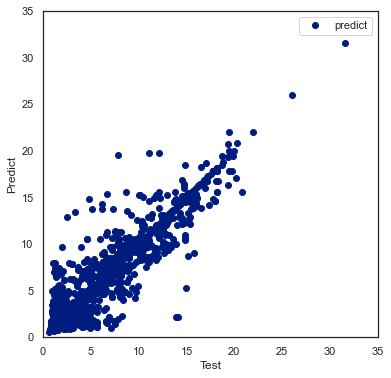

In [20]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_pred = pd.DataFrame({
    "test": y_test.values,
    "predict": y_test_pred_grid_sugar
}).set_index("test").sort_index()

ph_test_pred.plot(marker='o', ls="", ax=ax)
ax.set(xlabel="Test", ylabel="Predict", xlim=(0,35), ylim=(0,35));

## Question 6 *(Optional)*

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.